In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#for text proccessing
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

#for visualision
from matplotlib.pyplot import plot
import seaborn as sns

import joblib
#for saving the model for app requiremnts




In [2]:
df = pd.read_csv('data/depression_dataset_10000.csv')
df.head()

,id,text,sadness_score,anxiety_score,fatigue_score,sleep_issues,social_withdrawal,concentration_issues,mood_swings,label
0,6253,Feeling productive and hopeful. recently,3,3,0,0,0,0,0,0
1,4685,Feeling overwhelmed and down. today,5,5,5,1,0,1,1,1
2,1732,"Hey, No energy to get out of bed. lately",6,4,10,1,1,1,0,1
3,4743,Feeling hopeless and tired all the time. today,7,3,7,1,1,0,0,1
4,4522,"Ugh, I can't concentrate and I'm so tired. thi...",9,10,6,1,1,1,1,1


In [3]:
numeric_features = ['sadness_score', 'anxiety_score',
                    'fatigue_score', 'sleep_issues', 'social_withdrawal', 'concentration_issues', 'mood_swings','label']
numeric_X = df[numeric_features]
y = df['label']
print(numeric_X)

      sadness_score  anxiety_score  fatigue_score  sleep_issues  \
0                 3              3              0             0   
1                 5              5              5             1   
2                 6              4             10             1   
3                 7              3              7             1   
4                 9             10              6             1   
...             ...            ...            ...           ...   
9995              1              3              2             0   
9996              2              3              2             0   
9997              3              0              2             0   
9998              7              8              6             1   
9999              2              2              0             0   

      social_withdrawal  concentration_issues  mood_swings  label  
0                     0                     0            0      0  
1                     0                     1            1 

In [4]:
tfidf = TfidfVectorizer(max_features=500)
#max 500 words describe your situation
text_X =  tfidf.fit_transform(df['text'])

#now you can tell ohw you feel
#no shit please!


In [5]:
#combining both numerical and textual data

X = hstack([numeric_X, text_X])
print("we are jonied now..")

we are jonied now..


In [6]:
#spliting the dataset

#dont mind these spaces

y = y.reset_index(drop=True)

#i had an error

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)
#80-20 you know the drill
#if you dont go study
#just kidding, keep reading
print("data broke down")

data broke down


In [7]:
print(X_train.shape)
print(y_train.shape)

(8000, 88)
(8000,)


In [8]:
#training the model
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate= 0.1,
    subsample= 0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
print('training done for this ...')

xgb_clf.fit(X_train, y_train)
print('model fitting done...')


training done for this ...
model fitting done...


c:\Users\64pul\OneDrive\Documents\advanced-depression-predictor\depression_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:19:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [9]:
#the error was that i wrote y_test, y_train not y_train, y_test seriously
#this is honestly the most pettiest error ive ever seen
print('depressed people, im doing this for us!')
print('all hail kafka!')

depressed people, im doing this for us!
all hail kafka!


In [10]:
#evaluation of the model

y_pred = xgb_clf.predict(X_test)

print("accuracy report: ", accuracy_score(y_test, y_pred))
print("classification report: ", classification_report(y_test, y_pred))
print("confusion matrix: " ,confusion_matrix(y_test, y_pred))

accuracy report:  1.0
classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

confusion matrix:  [[1000    0]
 [   0 1000]]


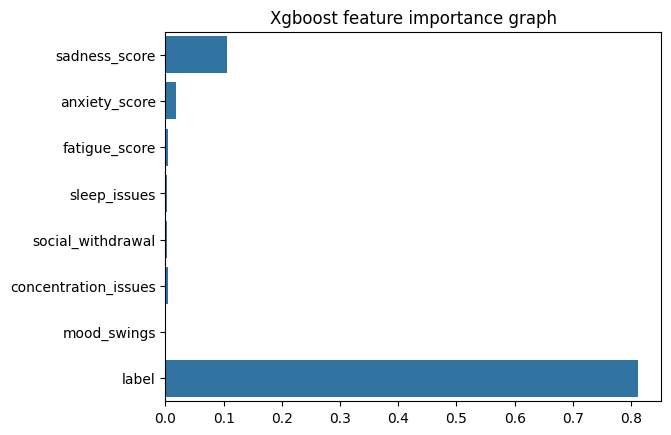

In [11]:
#feature importance

import matplotlib.pyplot as plt

importance = xgb_clf.feature_importances_[:len(numeric_features)]
#only the numeric features are being plotted

sns.barplot(x=importance, y=numeric_features)
plt.title("Xgboost feature importance graph")
plt.show()

In [12]:
#top vectorised words that are influencing the prediction

tfidf_features = tfidf.get_feature_names_out()
#kick names, take ass.
#kiddin, extract their names

text_importance = xgb_clf.feature_importances_[len(numeric_features):]
top_indices = np.argsort(text_importance)[-10:]
#top 10 words 

print("top 10 words that determine the prediction")
for i in top_indices[::-1]:
    print(tfidf_features[i], round(text_importance[i],4))


top 10 words that determine the prediction
feel 0.0173
bed 0.0139
anything 0.0119
tired 0.0079
feeling 0.0002
today 1e-04
and 0.0
with 0.0
to 0.0
time 0.0


In [13]:
#saving the model
joblib.dump(xgb_clf, "depression_xgb_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print(" Model and TF-IDF vectorizer saved for app deployment")



 Model and TF-IDF vectorizer saved for app deployment


In [14]:
#user-friendly prediction function

def predict_depression(user_input_features, user_text):
    #the scores and the texts

    input_numeric = pd.DataFrame([user_input_features])
    input_text = tfidf.transform([user_text])
    input_combined = hstack([input_numeric, input_text])

    pred = xgb_clf.predict(input_combined)[0]
    prob = xgb_clf.predict_proba(input_combined)[0][1]
    return {"prediction:": int(pred), "probability:": round(prob,3)}

example_features = {
    "sadness_score":7, "anxiety_score":6, "fatigue_score":8,
    "sleep_issues":1, "social_withdrawal":1, "concentration_issues":1,
    "mood_swings":0, "label": 0
}
example_text = "I feel hopeless and cannot focus on anything."

print(X_train.shape)  # (8000, 88)

numeric_features_Count = 8
text_features_count = 88 - numeric_features_Count
print(text_features_count)

predict_depression(example_features, example_text)





(8000, 88)
80


{'prediction:': 0, 'probability:': np.float32(0.007)}

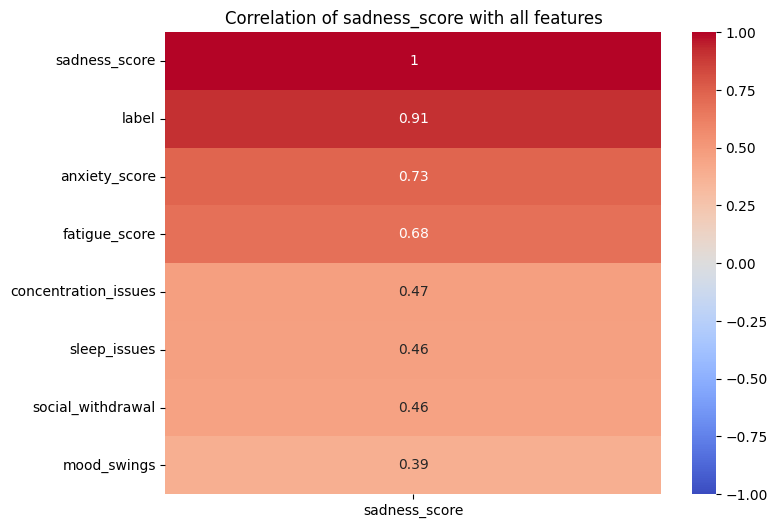

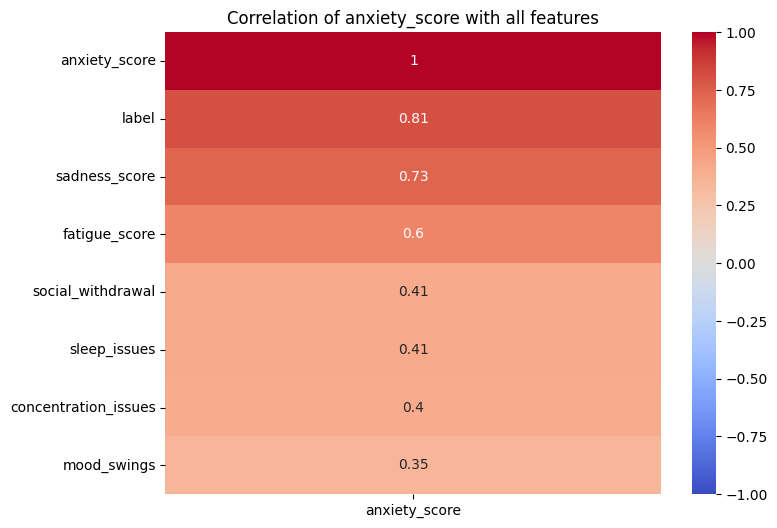

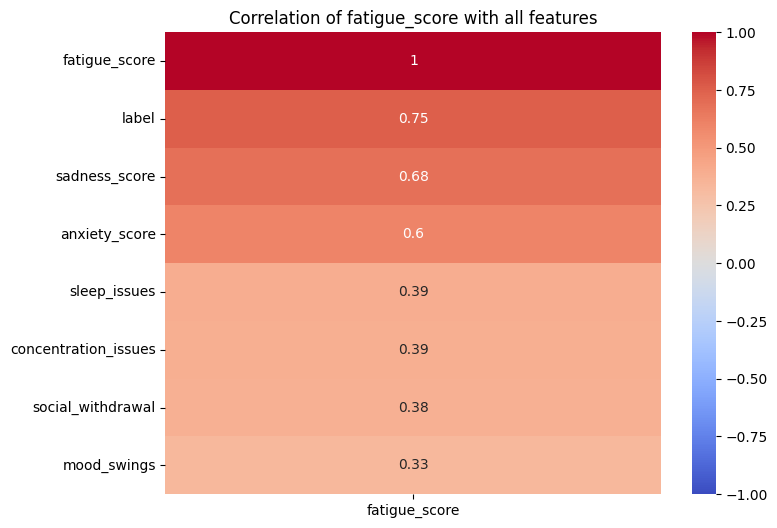

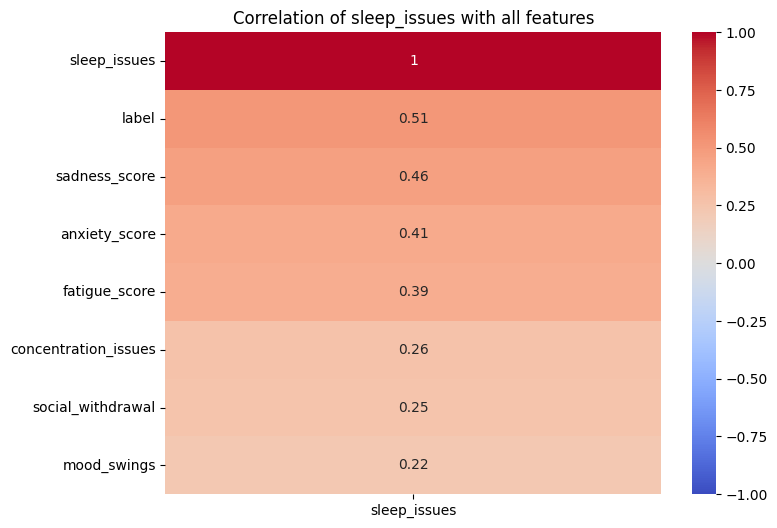

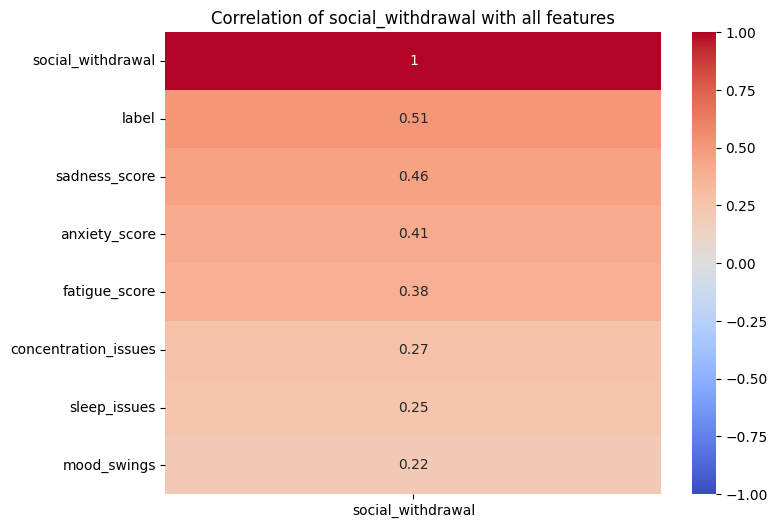

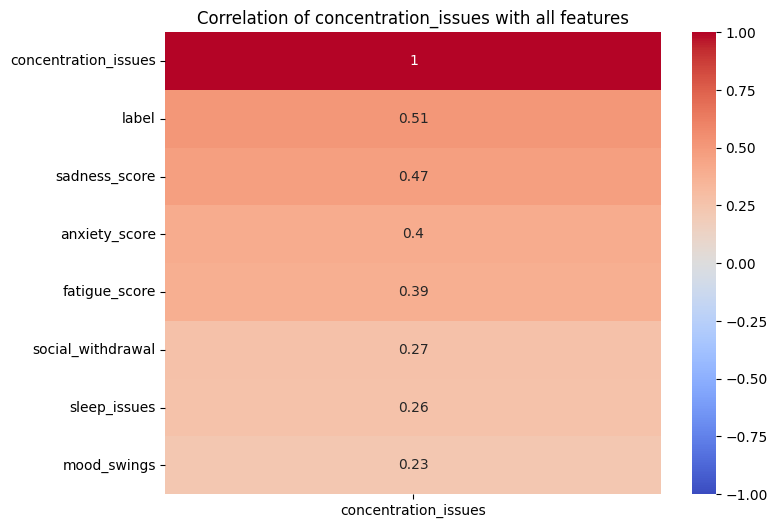

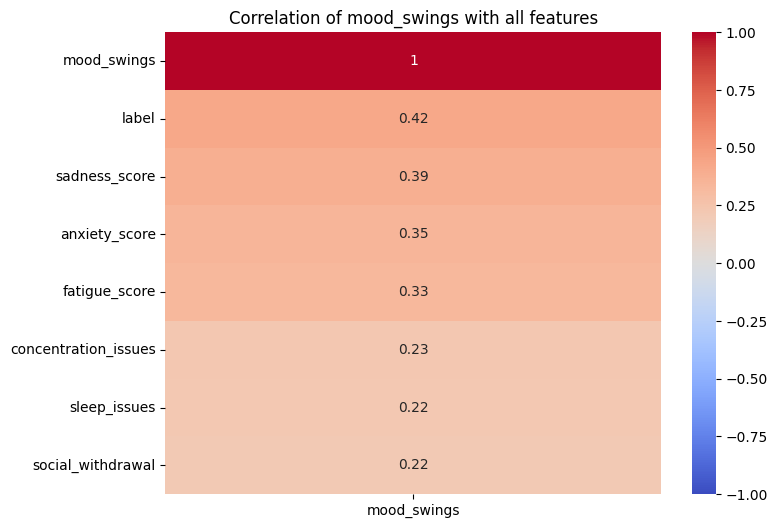

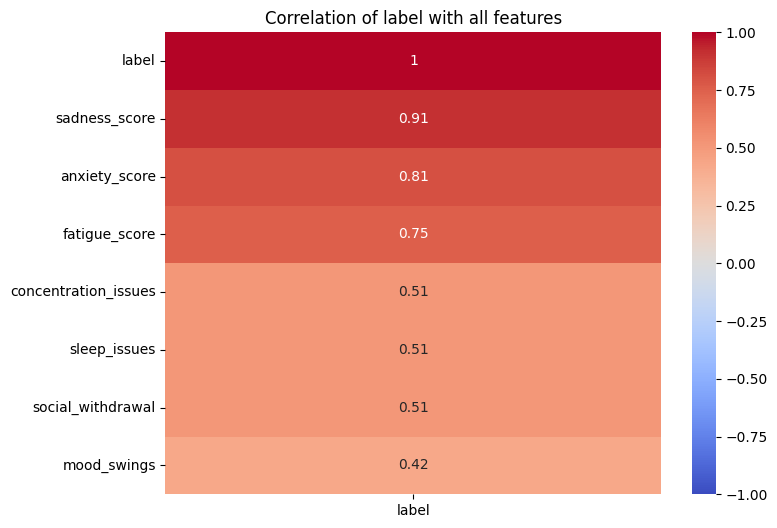

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = [
    "sadness_score",
    "anxiety_score",
    "fatigue_score",
    "sleep_issues",
    "social_withdrawal",
    "concentration_issues",
    "mood_swings",
    "label"
]

for feature in numeric_cols:
    plt.figure(figsize=(8,6))
    
    # calculate correlation of this feature with all numeric_cols
    corr_matrix = df[numeric_cols].corr()[[feature]].sort_values(by=feature, ascending=False)
    
    # plot heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation of {feature} with all features")
    plt.show()


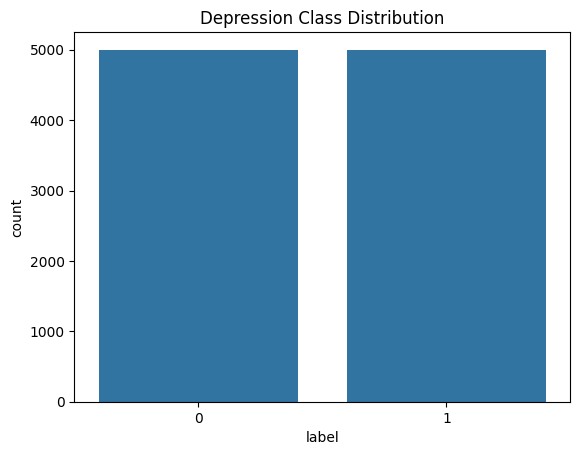

In [16]:
sns.countplot(x=y)
plt.title("Depression Class Distribution")
plt.show()


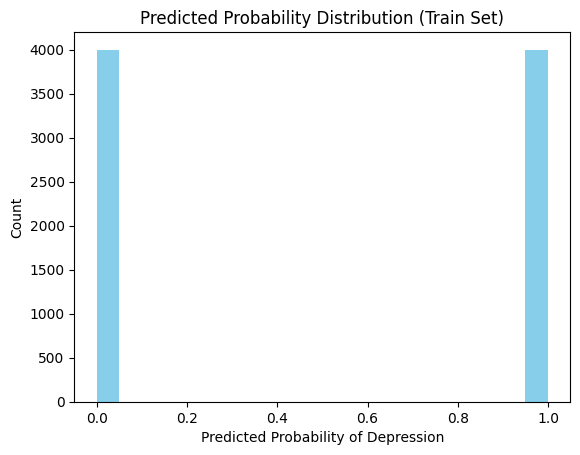

In [17]:
probs = xgb_clf.predict_proba(X_train)[:,1]

plt.hist(probs, bins=20, color='skyblue')
plt.xlabel("Predicted Probability of Depression")
plt.ylabel("Count")
plt.title("Predicted Probability Distribution (Train Set)")
plt.show()


In [18]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


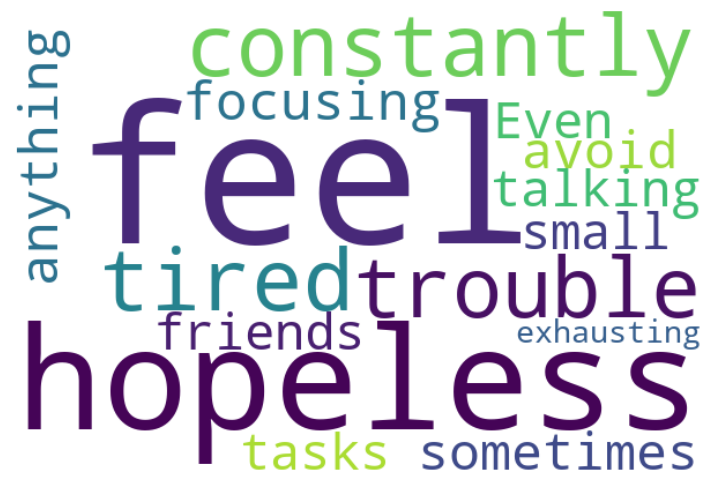

In [19]:
# Example user text (proper Python string)
user_text = """I feel hopeless and constantly tired. 
I have trouble focusing on anything, and sometimes I avoid talking to friends. 
Even small tasks feel exhausting."""


from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=600, height=400, background_color='white').generate(user_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [20]:
%pip install collections


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


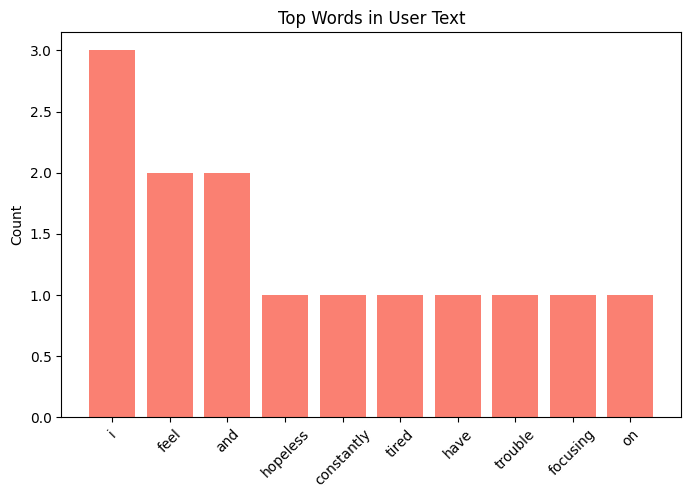

In [21]:
from collections import Counter
import matplotlib.pyplot as plt

words = user_text.lower().split()
words = [w.strip(".,!?") for w in words] 

word_counts = Counter(words)
top_words = word_counts.most_common(10)
labels, counts = zip(*top_words)

plt.figure(figsize=(8,5))
plt.bar(labels, counts, color='salmon')
plt.title("Top Words in User Text")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


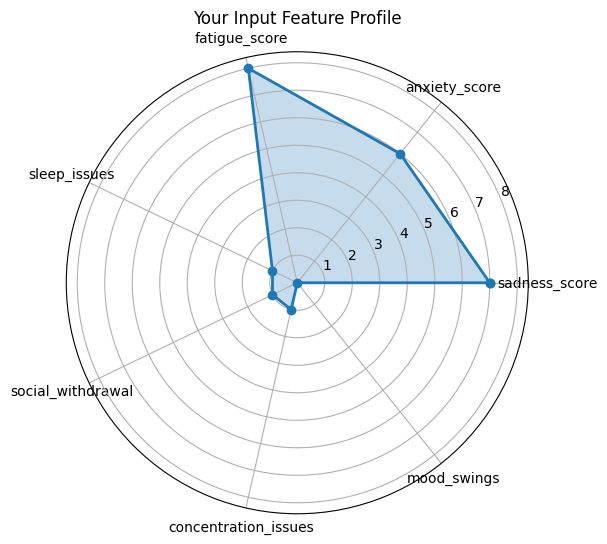

In [23]:
# Example numeric input
user_features = {
    "sadness_score": 7,
    "anxiety_score": 6,
    "fatigue_score": 8,
    "sleep_issues": 1,
    "social_withdrawal": 1,
    "concentration_issues": 1,
    "mood_swings": 0
}



import numpy as np

labels = list(user_features.keys())
values = list(user_features.values())
values += values[:1]  # close the loop
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, values, 'o-', linewidth=2)
ax.fill(angles, values, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Your Input Feature Profile")
plt.show()
